### Process_CoreBx_map_view_refac

Read the interpolated DEMs for the entire island and do map analysis.
January 2022

This reads the .nc file created by `CoreBx_island_refac` and `CoreBx_island_std_err_refac`
TODO:
* Correct aspect ratio on maps?
* Equal axes for all line plots?
* Add colorbars. Add labels to colorbars
* Add a), b), ...
* Remove titles?
* If the x, y labeling changes in CoreBx_multi, then correct here too.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr
import pandas as pd
import pickle
import netCDF4 as netcdf
from scipy import interpolate, signal
from CoreBx_funcs import *
%matplotlib inline

# These commands choose fonts that are editable in svg format
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# colors
dblue = '#1f77b4'
red3 = ['#fee0d2','#fc9272','#de2d26']
# oranges from ColorBrewer https://colorbrewer2.org/#type=sequential&scheme=PuBu&n=5
cols=['#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603']
blue5=['#f1eef6','#bdc9e1','#bdc9e1','#2b8cbe','#045a8d']
green5=['#edf8e9','#bae4b3','#74c476','#31a354','#006d2c']

# This is the colormap made in SurferClr2Cmap.ipynb from NorthCore_ElevationShader_v2.clr
fp = open('cmap_ncb.pkl', 'rb')
cmap_ncb = pickle.load(fp)
fp.close()

tcmap=cmap_ncb
tcmap.set_bad(color='darkgray')

In [2]:
# Dates for DEMs
dates = ([\
         "2019-08-30",\
         "2019-09-12",\
         "2019-10-11",\
         "2019-11-26",\
         "2020-02-09",\
         "2020-04-09",\
         "2020-08-05",\
         "2020-08-09",\
         "2020-09-28",\
         "2021-05-30"])

dem_path ='C:/crs/proj/2019_DorianOBX/Dorian_paper_analyses/rotated_dems/'

# these offsets are the mean anomaly relative to the 10-map mean per Analyze_rotated_stable_points_refac
offset = np.array([0.00168195,  0.02229009, -0.02397204, -0.01150765, -0.07320715, -0.02726184,
 -0.03547332, -0.02953579, -0.02719979,  0.00756222])

MHHW = 0.4 #elevation of MHHW per VDATUM

# hole-filling options
holes = (["clip","extend"])
ihole = 1 # pick 1 or 2d

# Read in a dict, where analysis region is defined by:
#  name
#  e0 - UTM Easting of origin [m]
#  n0 - UTM Northing of origin [m]
#  xlen - Length of alongshore axis [m]
#  ylen - Length of cross-shore axis [m]
#  dxdy - grid size (must be isotropic right now) [m]
#  theta - rotation CCW from x-axis [deg]
#  xs_end - number of grid cells to approximate limit of overwash terrace
#  d_end - number of grid cells to 
r = yaml2dict('island_box.yml')
print(r)

{'name': 'ncorebx_refac', 'e0': 378490.0, 'n0': 3855740.0, 'xlen': 36500.0, 'ylen': 1500.0, 'dxdy': 1.0, 'theta': 42.0}


In [3]:
# read in the multi-map .nc file
fn = 'C:/crs/proj/2019_DorianOBX/Dorian_paper_analyses/rotated_dems/ncorebx_refac.nc'
dsa = xr.open_dataset(fn)
dsaa = np.squeeze(dsa.to_array())
nmaps,ncross,nalong=np.shape(dsaa)
print('nmaps, ncross, nalong: ',nmaps,ncross,nalong)

# Correct for uniform offsets
for i in range(0,nmaps):
    dsaa[i,:,:] = dsaa[i,:,:] - offset[i] 

# NaNs below -1m
dsaa = dsaa.where(dsaa>=-1.0)

# Correct for uniform offsets
for i in range(0,nmaps):
    dsaa[i,:,:] = dsaa[i,:,:] - offset[i] 

# NaNs below -1m
dsaa = dsaa.where(dsaa>=-1.0)


nmaps, ncross, nalong:  10 1500 36500


#### Read in the digitized profile of dune crest profile and rotate to island coords

In [9]:
df=pd.read_csv("C:\\crs\\proj\\2019_DorianOBX\\WayneWright_flights\\CoreBx\\dune_line_2.csv",header = None)

xUTM=df.loc[:,0].values
yUTM=df.loc[:,1].values

xdune,ydune=UTM2Island(xUTM,yUTM)
y = np.arange(0,nalong+1.)
f = interpolate.interp1d(xdune,ydune,bounds_error=False,fill_value=np.nan)
ydunei = f(y)

### Read in the digitized profile for the back side at the ~1.25-m contour interval

Stat summary of island width (iswide)
  n, nnan, nvalid:  36501 3027 33474
  mean, std, min, max   : 245.375 108.560 0.000 584.452
  d5, d25, d50, d75, d95: 60.133 184.300 251.249 310.490 421.010


Text(0, 0.5, 'Cross-shore distance (m)')

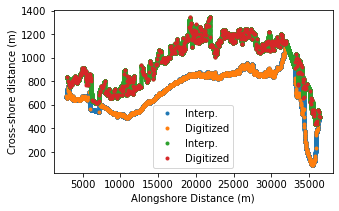

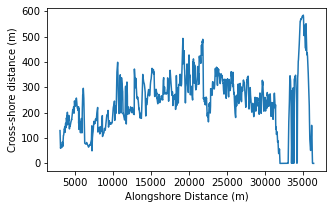

In [10]:
dfb=pd.read_csv("C:\\crs\\proj\\2019_DorianOBX\\WayneWright_flights\\CoreBx\\back_125_2.csv",header = None)
xUTMb=dfb.loc[:,0].values
yUTMb=dfb.loc[:,1].values

# rotate to alongshore/cross-shore coordinates
xback,yback=UTM2Island(xUTMb,yUTMb)

# interplote
fb = interpolate.interp1d(xback,yback,bounds_error=False,fill_value=np.nan)
ybacki = fb(y)

# ensure back >= dune
ybacki[ybacki<ydunei]=ydunei[ybacki<ydunei]
iswide = ybacki-ydunei

print("Stat summary of island width (iswide)")
stat_summary(iswide,iprint=True)

fig = plt.figure(figsize=(5,3))
plt.plot(y,ydunei,'.',label="Interp.")
plt.plot(xdune,ydune,'.',label='Digitized')
plt.plot(y,ybacki,'.',label="Interp.")
plt.plot(xback,yback,'.',label='Digitized')
plt.legend()
plt.xlabel('Alongshore Distance (m)')
plt.ylabel('Cross-shore distance (m)')

fig = plt.figure(figsize=(5,3))
plt.plot(y,iswide,'-')
plt.xlabel('Alongshore Distance (m)')
plt.ylabel('Cross-shore distance (m)')

## Code below has not been refactored...plan is to loop through some short sub-island interval and make legible plots

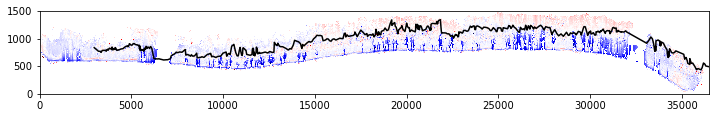

In [14]:
diffmap = np.squeeze(np.diff(dsaa,axis=0))
diffmap_tot = np.squeeze( dsaa[-1,:,:]-dsaa[0,:,:])
plt.figure(figsize=(12,7))
ax1=plt.subplot(411)
ax1.pcolormesh(diffmap[0,:,:],cmap='seismic',vmin=-4,vmax=4)
plt.plot(y,ybacki,'-k',label="Backbarrier")
plt.savefig('island_diffmap.png',bbox_inches='tight', format='png',dpi=200)

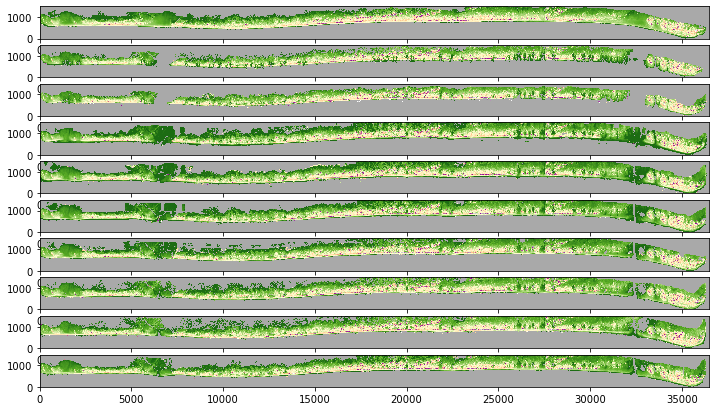

In [28]:
fig, ax = plt.subplots(10,1,figsize=(12,7))
for i in range(0,10):
    ax[i].pcolormesh(dsaa[i,:,:],cmap=tcmap,vmin=0,vmax=6)
plt.savefig('island_all_topos.png',bbox_inches='tight', format='png',dpi=200)

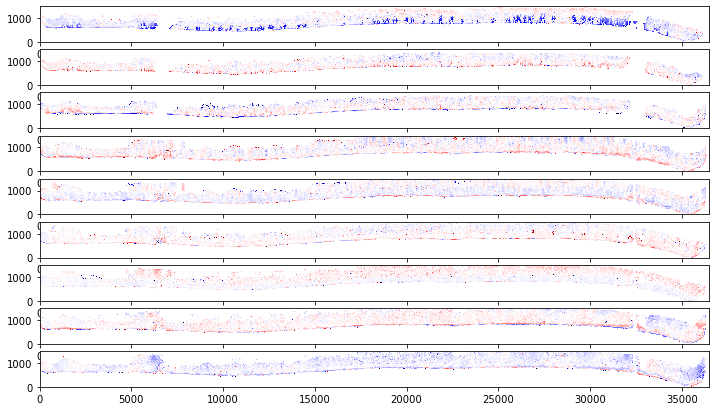

In [29]:
fig, ax = plt.subplots(9,1,figsize=(12,7))
for i in range(0,9):
    ax[i].pcolormesh(diffmap[i,:,:],cmap='seismic',vmin=-4,vmax=4)
plt.savefig('island_all_diffs.png',bbox_inches='tight', format='png',dpi=200)

C:\Users\csherwood\Anaconda3\envs\CRS\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


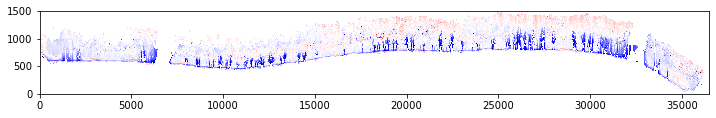

In [16]:
stdmap = np.squeeze(np.nanstd(dsaa,axis=0))
diffmap_tot = np.squeeze( dsaa[-1,:,:]-dsaa[0,:,:])
plt.figure(figsize=(12,7))
ax1=plt.subplot(411)
ax1.pcolormesh(stdmap[0,:,:],cmap='seismic',vmin=0,vmax=2)
plt.savefig('island_stddev_map.png',bbox_inches='tight', format='png',dpi=200)

(9, 1500, 36500)


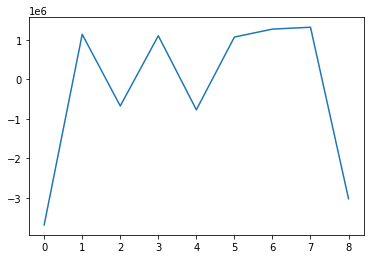

In [20]:
print(np.shape(diffmap))
dmaps = np.nansum(np.nansum(diffmap,axis=1),axis=1)
plt.plot(dmaps)

In [ ]:
for sn, seg in enumerate(segs):
    ss = seg
    se = ss+sl
    plt.figure(figsize=(12,7))
    ax1=plt.subplot(411)
    plt.plot(y[ss:se],dmax[0,ss:se],'.')
    #plt.plot(y[ss:se],dmax[0,ss:se],'.')
    plt.ylabel('Cross-shore dist. (m)')

    ax2=plt.subplot(412)
    plt.plot(y[ss:se],zmax_s0[ss:se],'.')
    plt.plot(y[ss:se],zmax_s1[ss:se],'.')
    plt.ylabel('Crest elev. (m)')

    ax3=plt.subplot(413)
    plt.plot(y[ss:se],zdiff[ss:se],'-')
    plt.ylabel('Elev. Change (m)')

    chana = np.cumsum(-zdiff[ss:se])
    ax3=plt.subplot(414)
    plt.plot(y[ss:se],chana)

    try:
        print('Seg. {} total channel area m^2/m: {:.2f}'.format(sn, chana[-1]/sl) )
    except:
        pass

    plt.figure(figsize=(12,7))
    ax1=plt.subplot(411)
    plt.plot(y[ss:se],dmax[0,ss:se],'.')
    #plt.plot(y[ss:se],dmax[0,ss:se],'.')
    plt.ylabel('Cross-shore dist. (m)')
    
    ax2=plt.subplot(412)
    plt.plot(y[ss:se],zmax_0[ss:se],'.')
    plt.plot(y[ss:se],zmax_1[ss:se],'.')
    plt.ylabel('Crest elev. (m)')

    ax3=plt.subplot(413)
    plt.plot(y[ss:se],zdiffu[ss:se],'-')
    plt.ylabel('Elev. Change (m)')

    chana = np.cumsum(-zdiffu[ss:se])
    ax3=plt.subplot(414)
    plt.plot(y[ss:se],chana)
    plt.ylabel('Cumulative Area (m^2)')

In [ ]:
diffmap = np.squeeze(np.diff(dsaa,axis=0))
diffmap_tot = np.squeeze( dsaa[-1,:,:]-dsaa[0,:,:])
print(np.shape(diffmap),file=sfile)
print("Stats for diffmap:",file=sfile)
for i in range(0,nmaps-1):
    print("\n2d stats for diffmap {} minus {}".format(dates[i+1],dates[i]),file=sfile)
    map_stats2d(np.squeeze(diffmap[i,:,:]),sfile)
print("\nStats for last minus first:",file=sfile)
map_stats2d(diffmap_tot, sfile)


title_str = '{0:s}'.format(r['name'].capitalize())  

xs_start = 0
xs_end = r['xs_end']
dxdy = r['dxdy']
xs_len = (xs_end-xs_start)
print('\nxs_len = ',xs_len,' cross-shore length: ',ncross*dxdy,file=sfile)

# calculate dhi
dhi = np.nanmax( dsaa[:,0:r['d_end'],:],axis=1)
print("Shape of dhi: ",np.shape(dhi),file=sfile)

mean_dhi = np.nanmean(dhi,1)
std_dhi = np.nanstd(dhi,1)
print("Mean dhi: ",mean_dhi,file=sfile)
print("Mean and std of dhi: {} {} (m)".format(mean_dhi, std_dhi),file=sfile)
sfile.close()

In [ ]:
# open the log file in append mode
sfile = open(statsfn, "a+")
# calculate centroid of each transect
print('Calculating centroids')

# calculate volumes    
# volumes for each transect in beach and overwash terrace (nmaps, nalong)
v = np.squeeze(np.nansum(dsaa[:,xs_start:xs_end,:]-MHHW,axis=1))

# volumes for each transect across entire cell (nmaps, nalong)
vall = np.squeeze(np.nansum(dsaa[:,:,:]-MHHW,axis=1))

# respective volume differences (nmaps-1, nalong)
vdiff = np.squeeze(np.diff(v,axis=0))
vdiffall = np.squeeze(np.diff(vall,axis=0))

print("Shape of v: ",np.shape(v),file=sfile)
print("Shape of vdiff: ",np.shape(vdiff),file=sfile)

# average transect volume for overwash terrace (nmaps)
m = np.mean(v,1)
# average volume change for overwash terrace (nmaps-1)
mean_dv = np.sum(vdiff,1)/(ncross*dxdy)
print("Average transect volume for ow terrace m: ",m,file=sfile)
print("Average volume change for ow terrace mean_dv",mean_dv,file=sfile)

# update sum over entire island
vsum = vsum+np.nansum(v,1)
vsumall = vsumall+np.nansum(vall,1)
vchange = vchange+np.sum(vdiff,1)
vchangeall = vchangeall+np.sum(vdiffall,1)

island_length = island_length+r['xlen']


# calculate elevations
mean_elev_xs_len = np.nanmean(np.nanmean(dsaa[:,0:r['xs_end'],:],1),1)
mean_elev_all = np.nanmean(np.nanmean(dsaa,1),1)
print("Mean elevation in overwash terrace (m):",mean_elev_xs_len,file=sfile )
print("Mean elevation in across entire island (m):",mean_elev_all,file=sfile )

pc = 100*np.nanmean(vdiff)/np.mean(v)
pcall = 100*np.nanmean(vdiffall)/np.mean(vall)

print("Pct volume change in overwash terrace m:",pc,"%",file=sfile)
print("Pct volume change in across entire island m:",pcall,"%",file=sfile)
sfile.close()

In [ ]:
##############################################################################
# Elevation plots
title_str = '{0:s} Dune Crest Elevation and Barrier Volume'.format(r['name'].capitalize())
plt.figure(figsize=(12,7))
ax1=plt.subplot(211)
plt.plot(dhi[0,:],color='dimgray',linewidth=3,label=dates[0])
plt.plot(dhi[1,:],color='tab:red',linewidth=2,label=dates[1])
plt.plot(dhi[2,:],color='tab:blue',linewidth=2,label=dates[2])
plt.plot(dhi[3,:],color='tab:orange',linewidth=2,label=dates[3])

plt.legend(loc='upper right')
ax1.xaxis.set_ticklabels([])
ax1.set_ylim(0,7.5)
plt.ylabel('Dune Crest Elevation (m)')
plt.text(0,.85*7.5,"a) Crest Elevation")
plt.title(title_str)

# Volume plot
ax2=plt.subplot(212)
plt.plot([0, nalong*dxdy],[m[0],m[0]],'--',color='dimgray',linewidth=1)
plt.plot([0, nalong*dxdy],[m[1],m[1]],'--',color='tab:red',linewidth=1)
plt.plot([0, nalong*dxdy],[m[2],m[2]],'--',color='tab:blue',linewidth=1)
plt.plot([0, nalong*dxdy],[m[3],m[3]],'--',color='tab:orange',linewidth=1)
lb = []
for i in range(0,4):
    lb.append("{0} {1:4.0f} m$^3$".format(dates[i],m[i]))
plt.plot(v[0,:],label=lb[0],color='dimgray',linewidth=3)
plt.plot(v[1,:],label=lb[1],color='tab:red',linewidth=2)
plt.plot(v[2,:],label=lb[2],color='tab:blue',linewidth=2)
plt.plot(v[3,:],label=lb[3],color='tab:orange',linewidth=2)
ax2.set_ylim(0,950)
plt.xlabel(r'Alongshore Distance (m)')
plt.ylabel(r'Volume (m$^3$/m)')
plt.legend(loc='upper right')
title_str = 'b) Volumes'

plt.text(0,.85*950,title_str)
fig_name = "{}_{}_elevation_volume.svg".format(r['name'],holes[ihole])
plt.savefig(fig_name,bbox_inches='tight', format='svg')


In [ ]:
##############################################################################
#  Plot map views
dcmap=plt.cm.seismic
dcmap.set_bad(color='darkgray')
# text locations
tx = 0.025*r['xlen']
ty = 0.9*r['ylen']
print("tx, ty:",tx,ty)

fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(9,9), constrained_layout=True)
ax[0,0].pcolormesh(dsaa[0,:,:],cmap=tcmap,vmin=0,vmax=6)
ax[1,0].pcolormesh(dsaa[1,:,:],cmap=tcmap,vmin=0,vmax=6)
ax[2,0].pcolormesh(dsaa[2,:,:],cmap=tcmap,vmin=0,vmax=6)
ax[3,0].pcolormesh(dsaa[3,:,:],cmap=tcmap,vmin=0,vmax=6)

ax[0,0].text(tx, ty,'a) {}'.format(dates[0]),c='lightgray')
ax[1,0].text(tx, ty,'b) {}'.format(dates[1]),c='lightgray')
ax[2,0].text(tx, ty,'c) {}'.format(dates[2]),c='lightgray')
ax[3,0].text(tx, ty,'d) {}'.format(dates[3]),c='lightgray')

ax[0,1].text(tx, ty,'e) {} minus {}'.format(dates[1],dates[0]))
ax[1,1].text(tx, ty,'f) {} minus {}'.format(dates[2],dates[1]))
ax[2,1].text(tx, ty,'g) {} minus {}'.format(dates[3],dates[2]))
ax[3,1].text(tx, ty,'h) {} minus {}'.format(dates[3],dates[0]))

ax[0,0].set_ylabel('Cross-shore Distance (m)')
ax[1,0].set_ylabel('Cross-shore Distance (m)')
ax[2,0].set_ylabel('Cross-shore Distance (m)')
ax[3,0].set_ylabel('Cross-shore Distance (m)')
ax[3,0].set_xlabel('Alongshore Distance (m)')

ax[0,1].pcolormesh(diffmap[0,:,:],cmap=dcmap,vmin=-3,vmax=3)
ax[0,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')
ax[1,1].pcolormesh(diffmap[1,:,:],cmap=dcmap,vmin=-3,vmax=3)
ax[1,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')
ax[2,1].pcolormesh(diffmap[2,:,:],cmap=dcmap,vmin=-3,vmax=3)
ax[2,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')
ax[3,1].pcolormesh(diffmap_tot,cmap=dcmap,vmin=-3,vmax=3)
ax[3,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')

ax[3,1].set_xlabel('Alongshore Distance (m)')

ax[0,0].xaxis.set_ticklabels([])
ax[1,0].xaxis.set_ticklabels([])
ax[2,0].xaxis.set_ticklabels([])
ax[0,1].xaxis.set_ticklabels([])
ax[1,1].xaxis.set_ticklabels([])
ax[2,1].xaxis.set_ticklabels([])
ax[0,1].yaxis.set_ticklabels([])
ax[1,1].yaxis.set_ticklabels([])
ax[2,1].yaxis.set_ticklabels([])
ax[3,1].yaxis.set_ticklabels([])

title_str = '{0:s} Elevation and Difference Maps'.format(r['name'].capitalize())
ax[0,0].set_title(title_str)

fig_name = "{}_{}_maps.png".format(r['name'],holes[ihole])
plt.savefig(fig_name, bbox_inches='tight', dpi = 300)

# open the log file in append mode
sfile = open(statsfn, "a+")
print('\nOverall statistics for hole filling with {}')
print('Vsum',vsum,' m3',file=sfile)
print('Volume change:',vchange, ' m3',file=sfile)
print('Volume change %',100*vchange/vsum[0], file=sfile)
print('Vsumall',vsumall,' m3',file=sfile)
print('Volume change all:',vchangeall, ' m3',file=sfile)
print('Volume change all %',100*vchangeall/vsumall[0],file=sfile)
print('Island length:',island_length,' m',file=sfile)
print('Mean volume change: ',vchange/island_length,' m3/m',file=sfile)

sfile.close()

# Plot total volumes
dtl = []
for date in dates:
    dtl.append(datetime.strptime(date, "%d %b %Y"))
dt = np.array(dtl)

fig, ax = plt.subplots(1)
fig.autofmt_xdate()
plt.plot(dt,vsumall/1e6,label="Entire island")
plt.plot(dt,vsum/1e6,label="Beach and overwash")
plt.ylabel('Million m$^3$')
plt.xticks(dt)
plt.grid()
plt.legend()
plt.title('Island Volume')
fig_name = 'island_volume_{}.svg'.format(holes[ihole])
plt.savefig(fig_name,bbox_inches='tight', format='svg')